# Task

Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.

In [99]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import heapq

## Part 1 - Create Grid World
+ Also, we need to ensure that there is at least one valid path between start and end

In [100]:
class GridWorld:
  def __init__(self, size=100, obstacle_count=100):
    self.size = size
    self.grid = np.zeros((size, size), dtype=int)
    self.start = None
    self.goal = None
    self.obstacle_count = obstacle_count
    self.generate_obstacles()
    self.set_start_goal()

  def generate_obstacles(self):
    count = 0
    while count < self.obstacle_count:
      x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
      if (x, y) != (0, 0) and (x, y) != (self.size - 1, self.size - 1) and self.grid[x, y] == 0:
        self.grid[x, y] = 1
        if not self.path_exists():
          self.grid[x, y] = 0 # Remove if there is no path that exists when the obstacle is added
        else:
          count += 1

  def path_exists(self):
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_pos = (0, 0)
    goal_pos = (self.size - 1, self.size - 1)
    visited = set()
    queue = deque([start_pos])

    while queue:
      x, y = queue.popleft()
      if (x, y) == goal_pos:
        return True
      for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if (0 <= nx < self.size and
          0 <= ny < self.size and
          self.grid[nx, ny] == 0 and
          (nx, ny) not in visited):
          visited.add((nx, ny))
          queue.append((nx, ny))
    return False

  def set_start_goal(self):
    free_spaces = [(i, j) for i in range(self.size) for j in range(self.size) if self.grid[i][j] == 0]
    self.start = random.choice(free_spaces)
    free_spaces.remove(self.start)
    self.goal = random.choice(free_spaces)

    # Set the start and goal positions
    self.grid[self.start] = -1 # Start marked as -1
    self.grid[self.goal] = -2 # GOal marked as -2

  def a_star_search(self):
    start, goal = self.start, self.goal
    grid = self.grid.copy()

    # Manhattan for a*
    def heuristic(a, b):
      return abs(a[0] - b[0]) + abs(a[1] - b[1])

    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {}
    cost_so_far = {}

    came_from[start] = None
    cost_so_far[start] = 0

    while frontier:
      current = heapq.heappop(frontier)[1]

      if current == goal:
        return True # Path found

      for delta in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        neighbor = (current[0] + delta[0], current[1] + delta[1])

        if (0 <= neighbor[0] < self.size and
          0 <= neighbor[1] < self.size and
          grid[neighbor] != 1):

          new_cost = cost_so_far[current] + 1

          if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
            cost_so_far[neighbor] = new_cost
            priority = new_cost + heuristic(goal, neighbor)
            heapq.heappush(frontier, (priority, neighbor))
            came_from[neighbor] = current

    return False # No path found

In [101]:
def plot_grid(world):
    plt.figure(figsize=(10, 10))
    plt.imshow(world.grid, cmap='gray_r')
    plt.scatter(world.start[1], world.start[0], color='green', label='Start', s=100)
    plt.scatter(world.goal[1], world.goal[0], color='red', label='Goal', s=100)
    plt.title("Grid World with Obstacles")
    plt.legend()
    plt.grid(True)
    plt.show()

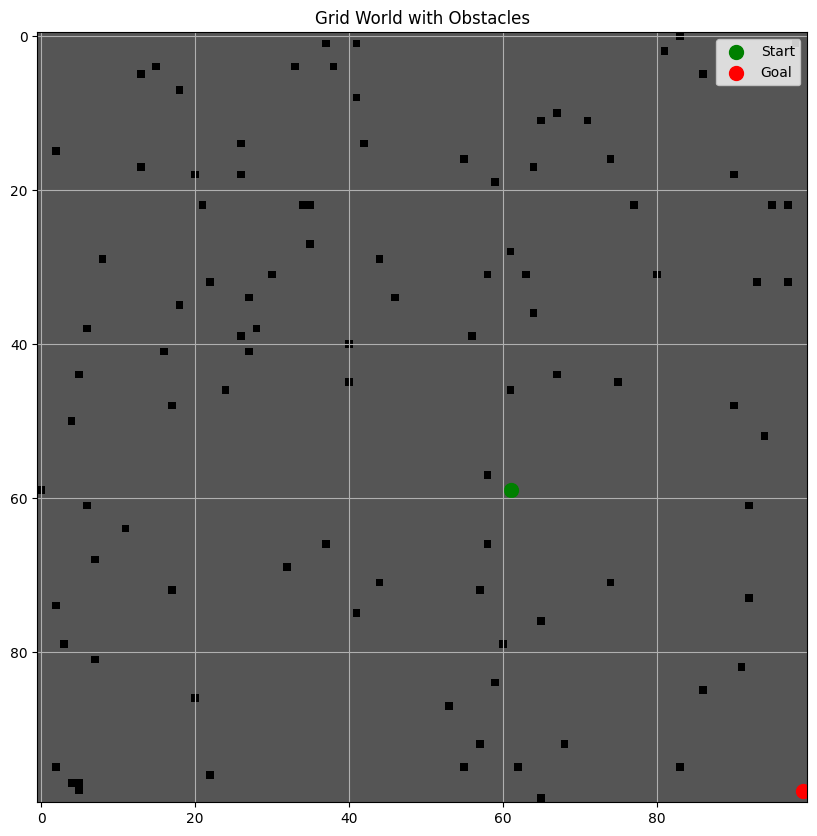

In [102]:
grid_world = GridWorld(size=100, obstacle_count=100)
plot_grid(grid_world)

In [103]:
if grid_world.a_star_search():
    print("Valid Path Exists")
else:
    print("No valid Path Exists")

Valid Path Exists


## Part 2 - Q-Learning Agent

Build an MDP based RL agent to optimise both policies and actions at every state.

In [104]:
class QLearningAgent:
  def __init__(self, environment, discount_factor=0.99, learning_rate=0.1, exploration_rate=0.1):
    self.environment = environment
    self.state_space = [(i, j) for i in range(environment.size) for j in range(environment.size) if environment.grid[i][j] != -1]
    self.action_space = ['up', 'down', 'left', 'right']
    self.discount_factor = discount_factor
    self.learning_rate = learning_rate
    self.exploration_rate = exploration_rate
    self.Q_values = defaultdict(lambda: defaultdict(float))
    self.rewards = self._initialize_rewards()

  def _initialize_rewards(self):
    rewards = {}
    for state in self.state_space:
      if state == self.environment.goal:
        rewards[state] = 100 # Goal reward
      else:
        rewards[state] = -1 # Step penalty
    return rewards

  def _get_next_state(self, current_state, action):
    i, j = current_state
    if action == 'up':
      i -= 1
    elif action == 'down':
      i += 1
    elif action == 'left':
      j -= 1
    elif action == 'right':
      j += 1

    # Checking teh boundaires and obstacles
    if 0 <= i < self.environment.size and 0 <= j < self.environment.size and self.environment.grid[i][j] != -1:
      return (i, j)
    else:
      return current_state # Invalid move

  def select_action(self, current_state):
    if random.uniform(0, 1) < self.exploration_rate:
      return random.choice(self.action_space) # Explore a random action
    else:
      # Exploit choose best action
      q_values = self.Q_values[current_state]
      max_q_value = max(q_values.values(), default=0)
      best_actions = [action for action, q in q_values.items() if q == max_q_value]
      return random.choice(best_actions) if best_actions else random.choice(self.action_space)

  def update_q_values(self, episodes=1000, max_steps_per_episode=100):
      for episode in range(episodes):
          current_state = self.environment.start
          steps = 0

          while current_state != self.environment.goal and steps < max_steps_per_episode:
              action = self.select_action(current_state)
              next_state = self._get_next_state(current_state, action)
              reward = self.rewards[next_state]

              max_future_q = max(self.Q_values[next_state].values(), default=0) # computes the maximum estimated future reward from state s’.
              td_target = reward + self.discount_factor * max_future_q
              td_delta = td_target - self.Q_values[current_state][action]
              self.Q_values[current_state][action] += self.learning_rate * td_delta

              current_state = next_state
              steps += 1

          self.exploration_rate = max(0.01, self.exploration_rate * 0.995)

          if (episode + 1) % 100 == 0:
              print(f"Episode {episode + 1}/{episodes} completed.")

          # Check if agent reached goal
          if current_state == self.environment.goal:
              print(f"Goal reached in episode {episode + 1} after {steps} steps.")

In [105]:
# Instantiate and train
q_learning_agent = QLearningAgent(grid_world)
q_learning_agent.update_q_values(episodes=1000)


Episode 100/1000 completed.
Episode 200/1000 completed.
Episode 300/1000 completed.
Episode 400/1000 completed.
Episode 500/1000 completed.
Episode 600/1000 completed.
Episode 700/1000 completed.
Episode 800/1000 completed.
Episode 900/1000 completed.
Episode 1000/1000 completed.


In [106]:
def visualize_policy(agent):
  grid_copy = np.copy(agent.environment.grid)
  for state in agent.state_space:
    i, j = state
    best_action = agent.select_action(state)

    # Arrow direction based on best action
    dx, dy = (0, -0.5) if best_action == 'up' else (0, 0.5) if best_action == 'down' else (-0.5, 0) if best_action == 'left' else (0.5, 0)

    plt.arrow(j, i, dx, dy, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

  plt.imshow(grid_copy, cmap='gray_r', origin='upper')
  plt.scatter(agent.environment.start[1], agent.environment.start[0], c='green', label='Start', s=100)
  plt.scatter(agent.environment.goal[1], agent.environment.goal[0], c='red', label='Goal', s=100)
  plt.title("Learned Policy Visualization")
  plt.legend()
  plt.grid(True)
  plt.show()

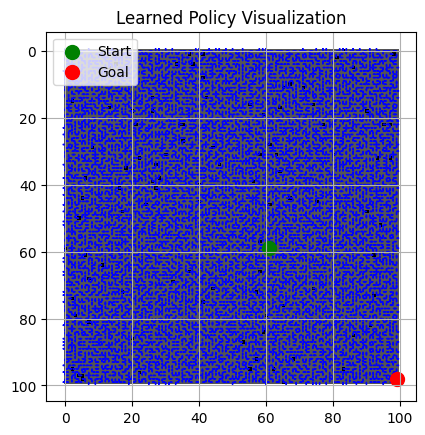

In [107]:
visualize_policy(q_learning_agent)

## Part 3 - Comparing with DP

In [108]:
class DPAgent:
  def __init__(self, environment, discount_factor=0.99, theta=0.00001):
    self.environment = environment
    self.state_space = [(i, j) for i in range(environment.size) for j in range(environment.size) if environment.grid[i][j] != 1]
    self.action_space = ['up', 'down', 'left', 'right']
    self.discount_factor = discount_factor
    self.theta = theta
    self.V = defaultdict(float)
    self.policy = defaultdict(lambda: random.choice(self.action_space))
    self.rewards = self._initialize_rewards()

  def _initialize_rewards(self):
    rewards = {}
    for state in self.state_space:
      if state == self.environment.goal:
        rewards[state] = 100
      else:
        rewards[state] = -1
    return rewards

  def _get_next_state(self, current_state, action):
    i, j = current_state
    if action == 'up':
      i -= 1
    elif action == 'down':
      i += 1
    elif action == 'left':
      j -= 1
    elif action == 'right':
      j += 1

    if 0 <= i < self.environment.size and 0 <= j < self.environment.size and self.environment.grid[i][j] != 1:
      return (i, j)
    else:
      return current_state

  def policy_evaluation(self):
    while True:
      delta = 0
      for state in self.state_space:
        v = self.V[state]
        new_v = 0
        action = self.policy[state]
        next_state = self._get_next_state(state, action)
        new_v = self.rewards.get(next_state, 0) + self.discount_factor * self.V[next_state]
        self.V[state] = new_v
        delta = max(delta, abs(v - self.V[state]))
      if delta < self.theta:
        break

  def policy_improvement(self):
    policy_stable = True
    for state in self.state_space:
      old_action = self.policy[state]
      action_values = {}
      for action in self.action_space:
        next_state = self._get_next_state(state, action)
        action_values[action] = self.rewards.get(next_state, 0) + self.discount_factor * self.V[next_state]
      best_action = max(action_values, key=action_values.get)
      self.policy[state] = best_action
      if old_action != best_action:
        policy_stable = False
    return policy_stable

  def policy_iteration(self):
    while True:
      self.policy_evaluation()
      if self.policy_improvement():
        break

In [109]:
# Instansiate and train the DP agent
dp_agent = DPAgent(grid_world)
dp_agent.policy_iteration()

In [110]:
# Evalutaion Functions
def evaluate_agent(agent, episodes=100):
    success_count = 0
    total_steps = 0
    for _ in range(episodes):
        current_state = agent.environment.start
        steps = 0
        while current_state != agent.environment.goal and steps < 1000:
            if isinstance(agent, QLearningAgent):
              action = agent.select_action(current_state)
            elif isinstance(agent, DPAgent):
              action = agent.policy[current_state]
            next_state = agent._get_next_state(current_state, action)
            current_state = next_state
            steps += 1

        if current_state == agent.environment.goal:
            success_count += 1
        total_steps += steps

    average_steps = total_steps / episodes if episodes > 0 else 0
    success_rate = (success_count / episodes) * 100
    return average_steps, success_rate

In [111]:
# Evaluation

dp_average_steps, dp_success_rate = evaluate_agent(dp_agent, episodes=100)
q_average_steps, q_success_rate = evaluate_agent(q_learning_agent, episodes=100)

print("DP Agent:")
print("Average steps to reach goal:", dp_average_steps)
print("Success rate:", dp_success_rate, "%")

print("\n")

print("Q-Learning Agent:")
print("Average steps to reach goal:", q_average_steps)
print("Success rate:", q_success_rate, "%")

DP Agent:
Average steps to reach goal: 77.0
Success rate: 100.0 %

Q-Learning Agent:
Average steps to reach goal: 1000.0
Success rate: 0.0 %


In [112]:
# Determining best policy
if dp_success_rate > q_success_rate:
    print("\nDP Policy is the best")
    best_learned_policy = dp_agent.policy
    best_policy_matrix = np.zeros((grid_world.size, grid_world.size), dtype=str)
    for state, action in best_learned_policy.items():
      best_policy_matrix[state] = action
    print(best_policy_matrix)
else:
    print("\nQ-Learning Policy is the best")
    best_learned_policy = q_learning_agent.Q_values


DP Policy is the best
[['d' 'd' 'd' ... 'd' 'r' 'd']
 ['d' 'd' 'd' ... 'd' '' 'd']
 ['d' 'd' 'd' ... 'd' 'd' 'd']
 ...
 ['d' 'd' 'd' ... 'd' 'd' 'd']
 ['d' 'd' 'd' ... 'r' 'r' 'r']
 ['r' 'r' 'r' ... 'r' 'r' 'u']]
